<a href="https://colab.research.google.com/github/simpleParadox/PSYCO-576-Fall-2020/blob/master/PSYCO_576_ML_for_Psychology_DW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome to the Second Data Workshop!**

Good job on the first data workshop.

To recap, in the first data workshop, we learned about



1.   The MNE package
2.   Visualizing raw data
3.   Preparing data for machine learning

We also briefly touched on ICA and how it can help to reduce noise in data.

In this notebook, the primary goal is to implement a machine learning model on the dataset

For machine learning, we will use a popular machine learning package called [scikit-learn](https://scikit-learn.org/stable/). We can also use python as it is by itself but scikit-learn is easier and reduces time and effort.

Note: Always use existing bug-free code - a good practice 😉.


The detailed learning objectives in this notebook cover:


1.   Understand what is a classification problem.
2.   Use scikit-learn to implement a dimensionality reduction technique.
3.   Fit a Logistic Regression model on the data.
4.   Temporal Decoding
5.   Permutation test?



We will use the same '[sample](https://mne.tools/stable/overview/datasets_index.html#sample-dataset)' dataset that we looked at in DW-1.

To recap, it contained data from various participants who were shown checkerboard patterns and given auditory tones, also a smiley face 🙂. Their EEG and MEG data was collected simultaneously and is stored in a .fif file.

In [16]:
#@title Run this cell to install packages and load variables.
# Install mne.
%%capture
!pip install mne

# Import packages.
import numpy as np
import os
import mne
import matplotlib.pyplot as plt


# Load dataset.
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)  # Read the raw .fif file.
raw.filter(2, 20)
events = mne.find_events(raw, 'STI 014')
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2}  # just use two
# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more
tmin, tmax = -0.200, 0.500
# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right

Let's check the dimensions of the **X** and **y** variables.

In [15]:
print(X.shape)

(123, 305, 11)


X is a 3-dimensional array🤯. 

The first dimension is contains the number of epochs - an epoch is a set of  for a channel. This is one sample.

The second dimension tells the number of channels.

The third dimension tells the number of readings for a channel. In this case, all channels have 11 observersations for that epoch.



In [12]:
mod_X = np.reshape(X,(X.shape[0],X.shape[1]*11))

In [13]:
mod_X.shape

(123, 3355)

In [ ]:
y.shape

(123,)

In [ ]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']


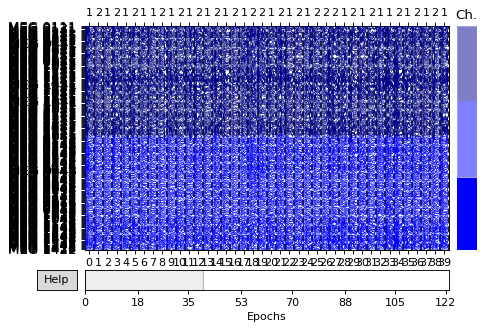

In [17]:
fig = epochs.plot(n_epochs=40, n_channels=206)
fig.show()